In [1]:
# Cell 1: imports + file check
import os, re, random
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

RSEED = 42
random.seed(RSEED)
np.random.seed(RSEED)

DATA_PATH = "spam.csv"  

print("exists:", os.path.exists(DATA_PATH))


exists: True


In [2]:
# Cell 2: load with header and preview
df = pd.read_csv(DATA_PATH, encoding='latin-1', header=0)
print("Columns:", df.columns.tolist())
display(df.head(8))
print("\nFile shape:", df.shape)


Columns: ['title', 'text', 'type']


,title,text,type
0,?? the secrets to SUCCESS,"Hi James,\n\nHave you claim your complimentary...",spam
1,?? You Earned 500 GCLoot Points,"\nalt_text\nCongratulations, you just earned\n...",not spam
2,?? Your GitHub launch code,"Here's your GitHub launch code, @Mortyj420!\n ...",not spam
3,[The Virtual Reward Center] Re: ** Clarifications,"Hello,\n \nThank you for contacting the Virtua...",not spam
4,"10-1 MLB Expert Inside, Plus Everything You Ne...","Hey Prachanda Rawal,\n\nToday's newsletter is ...",spam
5,AFE Model Casting Call,Model Casting Call\nThank you for taking the t...,not spam
6,AFE Model Casting Call,Model Casting Call\nThank you for taking the t...,not spam
7,Affordable American MBA degree ($180month),Today more than ever you need to upskill and r...,spam



File shape: (84, 3)


In [3]:
# Cell 3: combine and inspect labels
df['title'] = df['title'].fillna('').astype(str)
df['text']  = df['text'].fillna('').astype(str)
df['full_text'] = (df['title'].str.strip() + " " + df['text'].str.strip()).str.strip()

# Show some combined examples
display(df[['title','full_text','type']].head(8))

# Inspect label distribution
print("Label counts (raw):")
print(df['type'].value_counts(dropna=False))


,title,full_text,type
0,?? the secrets to SUCCESS,"?? the secrets to SUCCESS Hi James,\n\nHave yo...",spam
1,?? You Earned 500 GCLoot Points,?? You Earned 500 GCLoot Points alt_text\nCong...,not spam
2,?? Your GitHub launch code,?? Your GitHub launch code Here's your GitHub ...,not spam
3,[The Virtual Reward Center] Re: ** Clarifications,[The Virtual Reward Center] Re: ** Clarificati...,not spam
4,"10-1 MLB Expert Inside, Plus Everything You Ne...","10-1 MLB Expert Inside, Plus Everything You Ne...",spam
5,AFE Model Casting Call,AFE Model Casting Call Model Casting Call\nTha...,not spam
6,AFE Model Casting Call,AFE Model Casting Call Model Casting Call\nTha...,not spam
7,Affordable American MBA degree ($180month),Affordable American MBA degree ($180month) Tod...,spam


Label counts (raw):
type
not spam    58
spam        26
Name: count, dtype: int64


In [4]:
# Cell 4: cleaning
CUSTOM_STOPWORDS = {"the","and","is","in","it","of","to","a","i","you","for","on","that","this","with","was","are","be","have","at","as","but","not","or","we","they","he","she","from","by","an"}

def clean_text(s):
    s = str(s).lower()
    s = re.sub(r'<[^>]+>', ' ', s)                   # remove html
    s = re.sub(r'http\S+|www\.\S+', ' ', s)          # remove urls
    s = re.sub(r'\S+@\S+', ' ', s)                   # remove emails
    s = re.sub(r'[^a-z\s]', ' ', s)                  # keep letters and spaces
    s = re.sub(r'\s+', ' ', s).strip()               # collapse whitespace
    tokens = [tok for tok in s.split() if tok not in CUSTOM_STOPWORDS and len(tok)>1]
    return " ".join(tokens)

df['text_clean'] = df['full_text'].apply(clean_text)
display(df[['full_text','text_clean','type']].head(6))


,full_text,text_clean,type
0,"?? the secrets to SUCCESS Hi James,\n\nHave yo...",secrets success hi james claim your compliment...,spam
1,?? You Earned 500 GCLoot Points alt_text\nCong...,earned gcloot points alt text congratulations ...,not spam
2,?? Your GitHub launch code Here's your GitHub ...,your github launch code here your github launc...,not spam
3,[The Virtual Reward Center] Re: ** Clarificati...,virtual reward center re clarifications hello ...,not spam
4,"10-1 MLB Expert Inside, Plus Everything You Ne...",mlb expert inside plus everything need blockbu...,spam
5,AFE Model Casting Call Model Casting Call\nTha...,afe model casting call model casting call than...,not spam


In [5]:
# Cell 5: drop empties and duplicates, map labels
before = len(df)
df = df[df['text_clean'].str.strip() != ""].copy()
df = df.drop_duplicates(subset=['text_clean']).copy()
after = len(df)
print(f"dropped {before-after} empty/duplicate rows; new shape: {df.shape}")

# map labels -> binary (customize mapping if your labels differ)
df['label_bin'] = df['type'].astype(str).str.strip().str.lower().map(lambda x: 1 if x == 'spam' else 0)

print("Counts after mapping to binary (0=not spam, 1=spam):")
print(df['label_bin'].value_counts(dropna=False))


dropped 2 empty/duplicate rows; new shape: (82, 5)
Counts after mapping to binary (0=not spam, 1=spam):
label_bin
0    56
1    26
Name: count, dtype: int64


In [6]:
# Cell 6: check classes
if df['label_bin'].nunique() < 2:
    print("ERROR: Dataset contains only one class after mapping. Cannot train classifier.")
    print("-> Check 'type' column values above; make sure 'spam' and 'not spam/ham' are present.")
else:
    print("Good: dataset has both classes. Proceed to next cell.")


Good: dataset has both classes. Proceed to next cell.


In [7]:
# Cell 7: simple augmentation (random deletion) to balance classes if small and imbalanced
def random_deletion(sentence, p=0.15):
    tokens = sentence.split()
    if len(tokens) <= 1:
        return sentence
    kept = [t for t in tokens if random.random() > p]
    if len(kept) == 0:
        kept = [tokens[random.randrange(len(tokens))]]
    return " ".join(kept)

# Only do augmentation if you have imbalance and dataset is modest-sized
counts = df['label_bin'].value_counts().to_dict()
print("current counts:", counts)
if abs(counts.get(0,0) - counts.get(1,0)) > 0 and len(df) < 20000:
    maj = max(counts.values())
    min_class = min(counts, key=counts.get)
    need = maj - counts[min_class]
    print(f"Creating {need} augmented examples for minority class {min_class}...")
    samples = df[df['label_bin']==min_class]['text_clean'].tolist()
    aug_rows = []
    i = 0
    while len(aug_rows) < need:
        base = samples[i % len(samples)]
        aug = random_deletion(base, p=0.12 + random.random()*0.18)
        aug_rows.append({'text_clean': aug, 'label_bin': min_class})
        i += 1
    augdf = pd.DataFrame(aug_rows)
    df = pd.concat([df, augdf], ignore_index=True)
    print("Augmentation finished. New counts:", df['label_bin'].value_counts().to_dict())
else:
    print("Skipping augmentation (either balanced/enough data or too big).")


current counts: {0: 56, 1: 26}
Creating 30 augmented examples for minority class 1...
Augmentation finished. New counts: {1: 56, 0: 56}


train/test sizes: 89 23
TF-IDF shapes: (89, 5000) (23, 5000)
MultinomialNB accuracy: 0.8695652173913043
              precision    recall  f1-score   support

           0     0.8462    0.9167    0.8800        12
           1     0.9000    0.8182    0.8571        11

    accuracy                         0.8696        23
   macro avg     0.8731    0.8674    0.8686        23
weighted avg     0.8719    0.8696    0.8691        23

LogisticRegression accuracy: 0.8695652173913043
              precision    recall  f1-score   support

           0     0.8462    0.9167    0.8800        12
           1     0.9000    0.8182    0.8571        11

    accuracy                         0.8696        23
   macro avg     0.8731    0.8674    0.8686        23
weighted avg     0.8719    0.8696    0.8691        23

Best model: LogisticRegression
Confusion matrix:
 [[11  1]
 [ 2  9]]


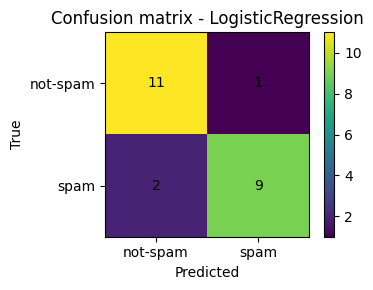

In [8]:
# Cell 8: train/test split, TF-IDF, train NB and LR, evaluate
X = df['text_clean'].values
y = df['label_bin'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED, stratify=y)
print("train/test sizes:", X_train.shape[0], X_test.shape[0])

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
Xtr = tfidf.fit_transform(X_train)
Xte = tfidf.transform(X_test)
print("TF-IDF shapes:", Xtr.shape, Xte.shape)

# Multinomial NB
mnb = MultinomialNB()
mnb.fit(Xtr, y_train)
yhat_mnb = mnb.predict(Xte)
print("MultinomialNB accuracy:", accuracy_score(y_test, yhat_mnb))
print(classification_report(y_test, yhat_mnb, digits=4))

# Logistic Regression with class weight
lr = LogisticRegression(max_iter=1500, class_weight='balanced', solver='liblinear', random_state=RSEED)
lr.fit(Xtr, y_train)
yhat_lr = lr.predict(Xte)
print("LogisticRegression accuracy:", accuracy_score(y_test, yhat_lr))
print(classification_report(y_test, yhat_lr, digits=4))

# Confusion matrix for the better model
from sklearn.metrics import confusion_matrix
acc_mnb = accuracy_score(y_test, yhat_mnb)
acc_lr  = accuracy_score(y_test, yhat_lr)
best_pred = yhat_lr if acc_lr >= acc_mnb else yhat_mnb
best_name = "LogisticRegression" if acc_lr >= acc_mnb else "MultinomialNB"
print("Best model:", best_name)

cm = confusion_matrix(y_test, best_pred)
print("Confusion matrix:\n", cm)
plt.figure(figsize=(4,3))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion matrix - " + best_name)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks([0,1], ['not-spam','spam']); plt.yticks([0,1], ['not-spam','spam'])
for (i,j),v in np.ndenumerate(cm):
    plt.text(j,i,int(v),ha='center',va='center')
plt.colorbar(); plt.tight_layout(); plt.show()


In [9]:
# Cell 9: save TF-IDF + model pipeline (optional)
import joblib
pipeline = {'tfidf': tfidf, 'model': lr}   # or mnb based on performance
joblib.dump(pipeline, "spam_pipeline.joblib")
print("Saved pipeline to spam_pipeline.joblib")


Saved pipeline to spam_pipeline.joblib


In [11]:
# save_pipeline_cell.ipynb
from sklearn.pipeline import Pipeline
import joblib

# assume `tfidf` and `lr` (or `mnb`) already exist from your training cell
pipeline = Pipeline([
    ('tfidf', tfidf),
    ('clf', lr)   # or ('clf', mnb)
])

joblib.dump(pipeline, 'spam_pipeline.joblib')   # writes to working directory
print("Saved pipeline to spam_pipeline.joblib")


Saved pipeline to spam_pipeline.joblib


In [19]:
# load and predict
import joblib
pipe = joblib.load('spam_pipeline.joblib')
sample = ["congratulations! you've won a prize — click here"]
pred = pipe.predict(sample)           # 0 or 1
probs = pipe.predict_proba(sample) if hasattr(pipe, "predict_proba") else None
print("pred:", pred, "probs:", probs)


pred: [1] probs: [[0.47526232 0.52473768]]
